In [ ]:
# default_exp dataprep

In [ ]:
#export
from fastai import *
from fastai.vision import *
from fastai.data_block import *
import nibabel as nib
from fastai.callbacks import *
import matplotlib

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = Path('/media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train')

# dataprep

> Definitions of custom classes and methods for handling MRI images following the dataBlock API.
* `MRImage`: class for manipulating MRI images
* `MRImageSegment`: carries MRImage segmentation masks
* `MRImageList`: like ImageList for Image
* `MRImageSegLabelList`: equivalent of Image 

The idea behind these classes is to wrap all slices within a given MRI and perform all operations (e.g:

transformations, visualizations, etc...) on each slice
using the `Image` and `ImageSegment` classes.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()
        
class MRImage(ItemBase):

    def __init__(self, imageList:Collection[Tensor]):
        self.slices = imageList if is_listy(imageList) else listify(imageList)
        self.px = torch.stack(self.slices)
        
    @property
    def data(self)->TensorImage: return self.px
        
    @property
    def shape(self)->Tuple[int,int,int,int]: return tuple([*self.data.shape])
    @property
    def size(self)->Tuple[int,int]: return (self.shape[0], self.shape[-2:])
    @property
    def device(self)->torch.device: return self.data.device
    
    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.shape)}'
        
        
    def apply_tfms(self, tfms, slicewise=True, **kwargs):
        "Apply different transformations on each slice if `slicewise` is True and the same ones otherwise"
        if slicewise: 
            x = MRImage([Image(s).apply_tfms(tfms, **kwargs).data for s in self.slices])
        else:
            _resolve_tfms(tfms)
            x = MRImage([Image(s).apply_tfms(tfms, do_resolve=False, **kwargs).data for s in self.slices])
        return x
    
    def to_one(self): 
        "Concatenate all slices into a single Image object"
        return Image(torch.cat([d for d in self.data], 2))
    
    def show(self, axs:plt.Axes=None, figsize:tuple=(40,40), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, slice_idxs=np.arange(5), **kwargs):
        "Show image on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        cmap = ifnone(cmap, defaults.cmap)
        assert min(slice_idxs) >=0 and max(slice_idxs) <= self.shape[0]
        slices = [self.slices[i] for i in slice_idxs]
        if axs is None: 
            cols = len(slices)
            fig,axs = plt.subplots(1, cols, figsize=figsize)
        
        assert len(axs) == len(slices)
        if y:
            yy = [y.slices[i] for i in slice_idxs]
            for x,y_,ax in zip(slices, yy, axs): 
                Image(x).show(ax=ax, y=ImageSegment(y_), **kwargs)
        else:
            for x,ax in zip(slices, axs): 
                Image(x).show(ax=ax, **kwargs)

In [ ]:
#export
class MRImageSegment(MRImage):
    "Support applying transforms to segmentation masks data in `px`."
    @property
    def data(self)->TensorImage:
        "Return this MRImage pixels as a `LongTensor`."
        return self.px.long()

    def apply_tfms(self, tfms, slicewise=True, **kwargs):
        "Apply different/same transformations on each slice depending on `slicewise` value"
        if slicewise: 
            x = MRImageSegment([ImageSegment(s).apply_tfms(tfms, **kwargs).data for s in self.slices])
        else:
            _resolve_tfms(tfms)
            x = MRImageSegment([ImageSegment(s).apply_tfms(tfms, do_resolve=False, **kwargs).data for s in self.slices])
        return x

    def show(self, axs:plt.Axes=None, figsize:tuple=(40,40), title:Optional[str]=None, hide_axis:bool=True,
        cmap:str='tab20', alpha:float=0.5, slice_idxs=np.arange(5), **kwargs):
        "Show the `MRImageSegment` on `ax`."
        cmap = ifnone(cmap, defaults.cmap)
        assert min(slice_idxs) >=0 and max(slice_idxs) <= self.shape[0]
        slices = [self.slices[i] for i in slice_idxs]
        if axs is None: 
            cols = len(slices)
            fig,axs = plt.subplots(1, cols, figsize=figsize)
            
        assert len(axs) == len(slices)
        for x,ax in zip(slices, axs): 
            ImageSegment(x).show(ax=ax, **kwargs)
        
    def save(self, fn:PathOrStr):
        pass

    def reconstruct(self, t:Tensor): return MRImageSegment(t)


In [ ]:
#export
def loadnii(fn):
    return nib.load(fn).get_data()

def open_mri(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', loader=loadnii,  cls:type=MRImage,
             after_open:Callable=None)->MRImage:
    "Return ` MRImage` object created from any MRI file format `fn` using its custom `loader`."
    x = loader(fn)
    h, w , n_slices = x.shape
    res = []
    for i in range(n_slices):
        a = PIL.Image.fromarray(x[:,:,i]).convert(convert_mode)
        if after_open: a = after_open(a)
        a =  pil2tensor(a, np.float32) 
        if div: a.div_(255)
        res.append(a)
    return cls(res)

def open_mri_mask(fn):
    return open_mri(fn, div=False, convert_mode='L', cls=MRImageSegment)

MRImage (10, 3, 216, 256)


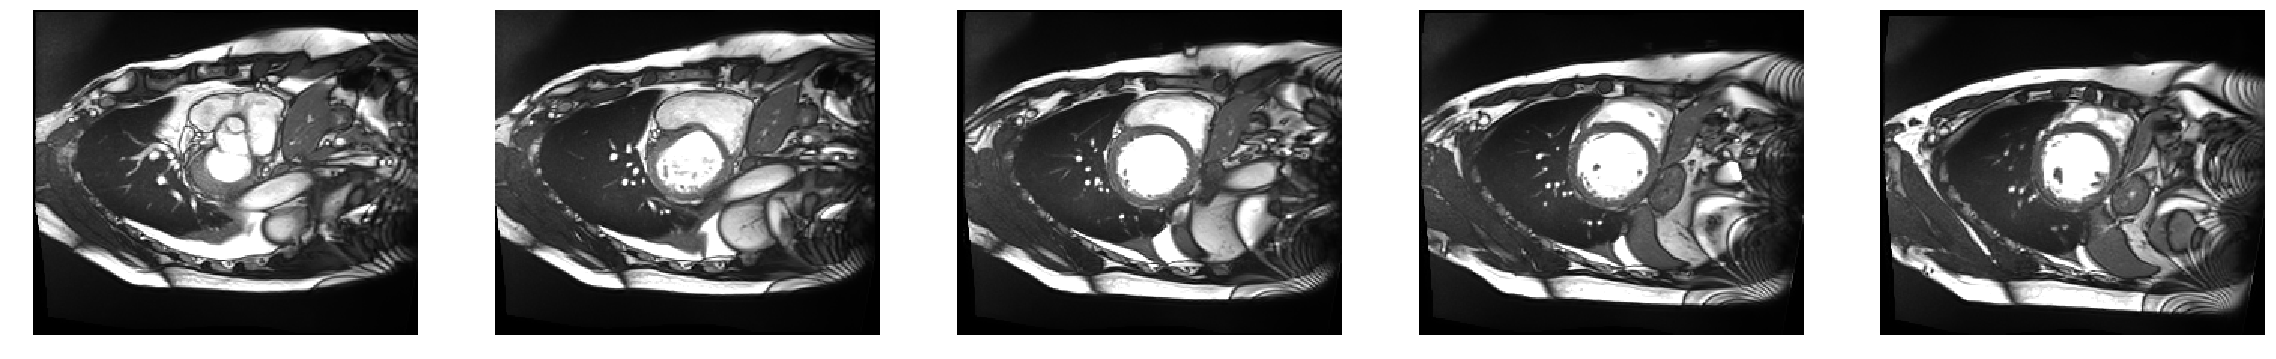

MRImageSegment (10, 1, 216, 256)


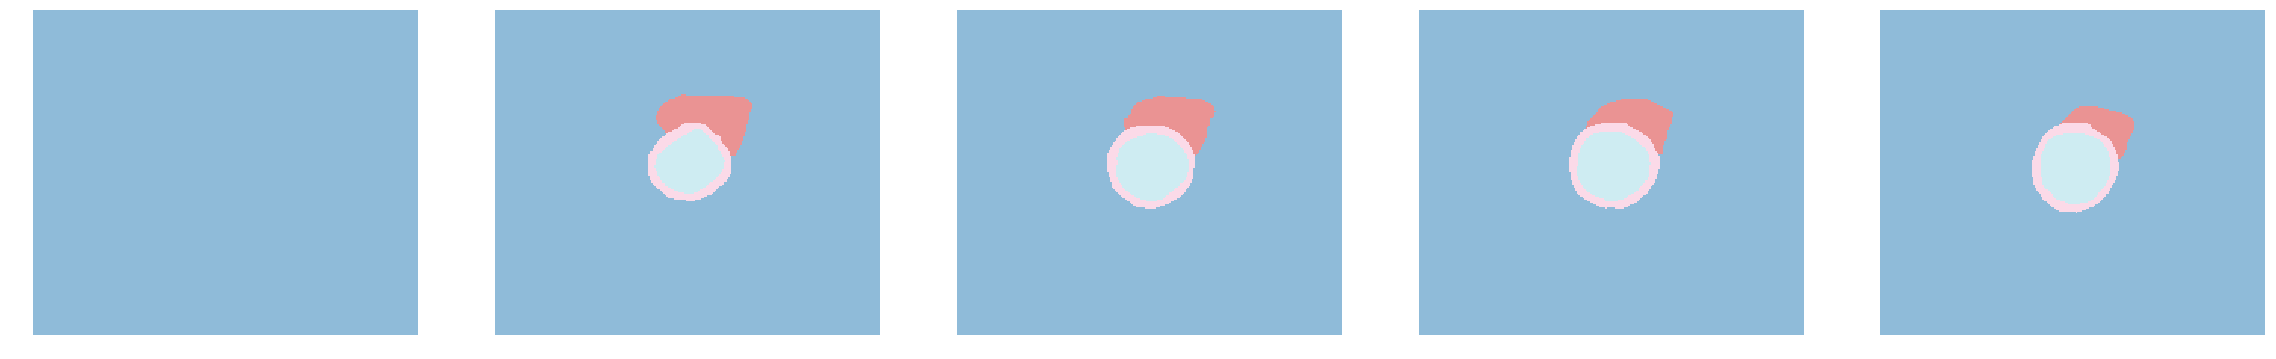

In [ ]:
fn = str(path/'patient001/patient001_frame01.nii.gz')
get_mask = lambda fn: fn[:-7]+'_gt.nii.gz'
mri = open_mri(fn)
mri_mask = open_mri_mask(get_mask(fn))
for m in [mri, mri_mask]:
    print(m)
    m.show()
    plt.show()

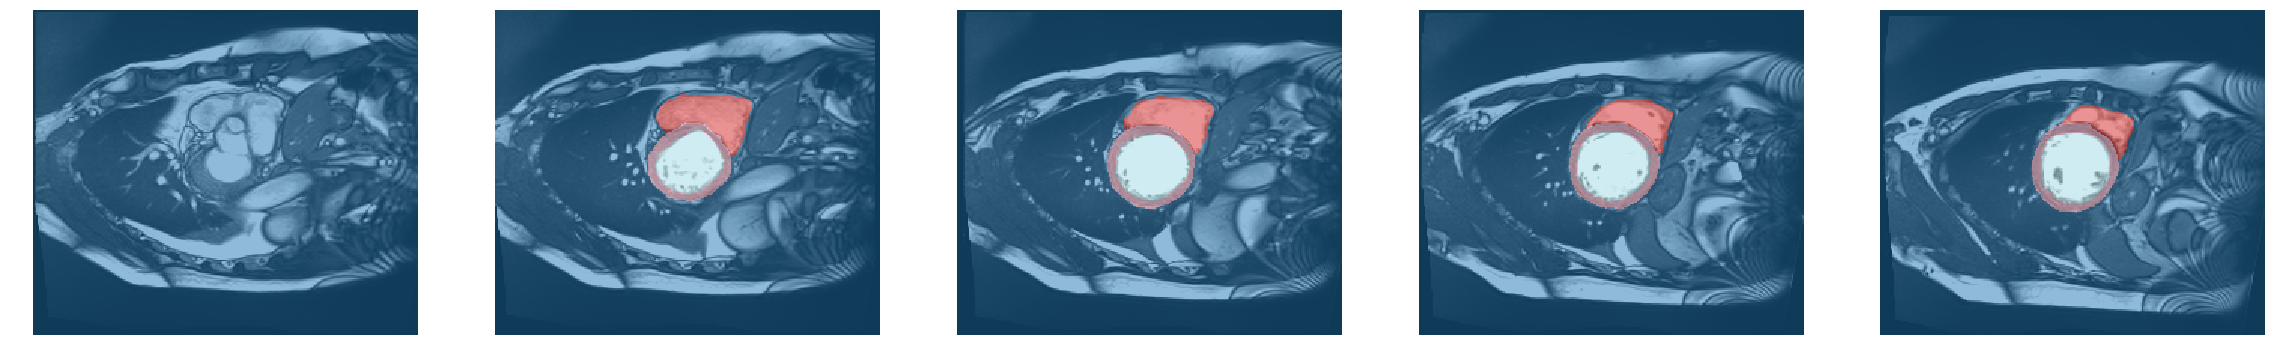

In [ ]:
mri.show(y=mri_mask, )

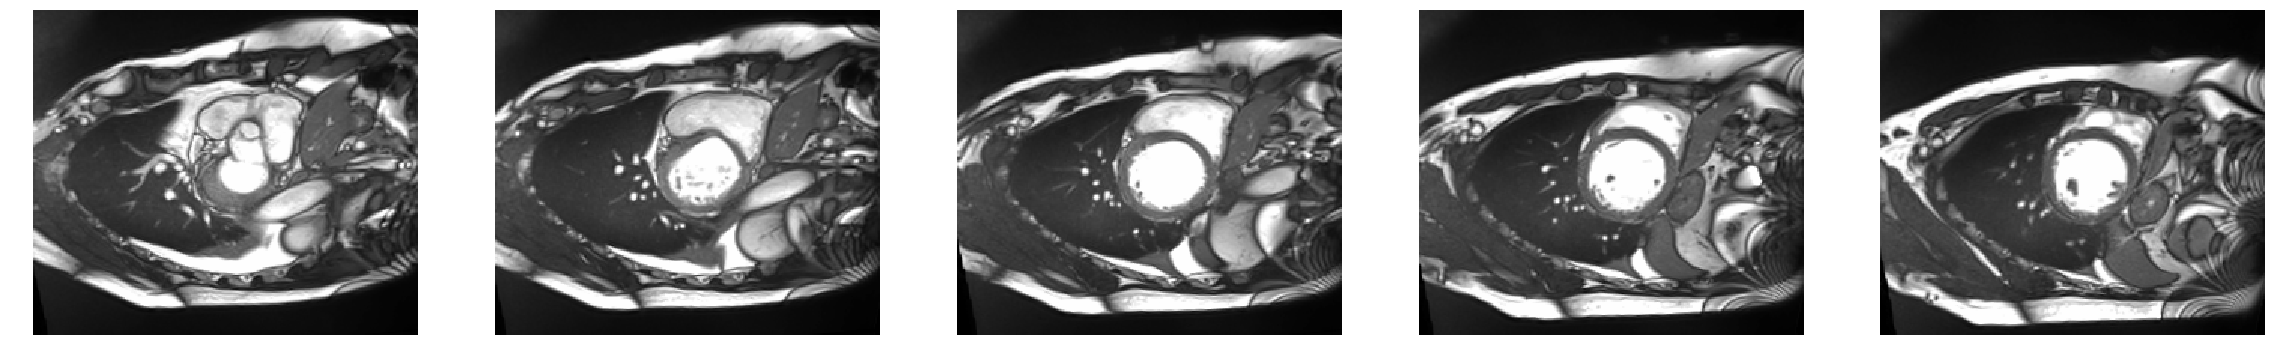

In [ ]:
tfms = get_transforms()
mri.apply_tfms(tfms[0], slicewise=False).show()

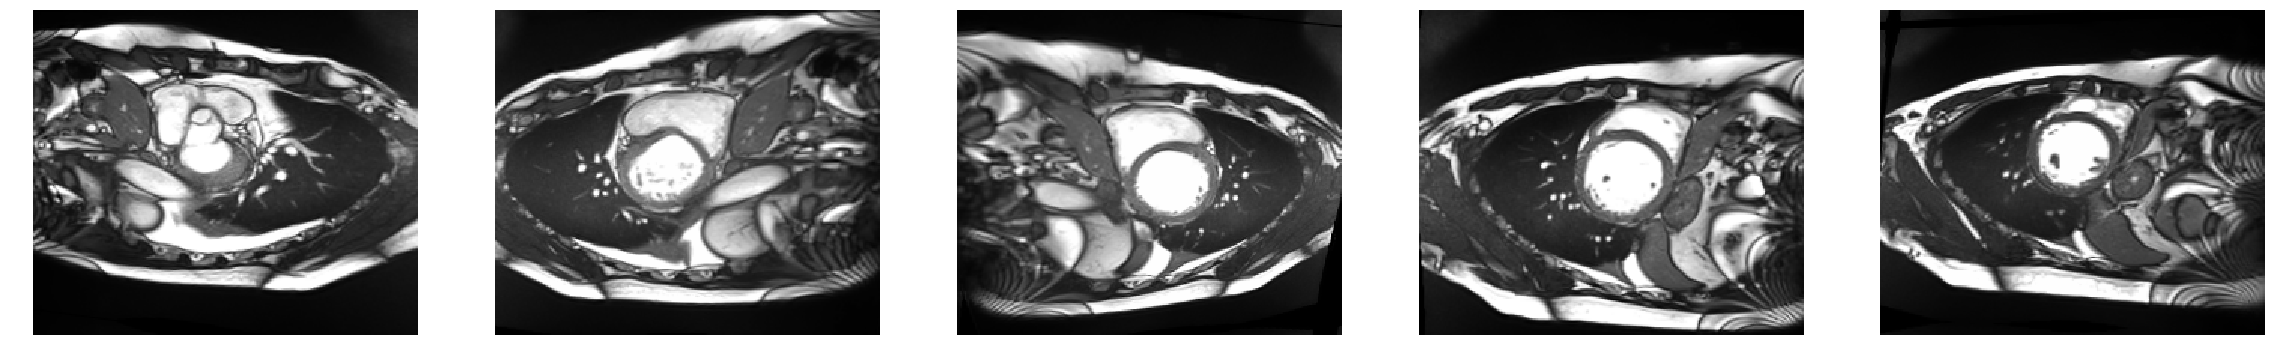

In [ ]:
mri.apply_tfms(tfms[0], slicewise=True).show()

In [ ]:
#export
class MRImageList(ImageList):
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_mri(fn, convert_mode=self.convert_mode, after_open=self.after_open)
    
    def reconstruct(self, t:Tensor): return MRImage(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=10, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows, cols = len(xs), xs[0].shape[0]
        axss = subplots(rows, cols, figsize=(60, 10))
        for x,y,axs in zip(xs, ys, axss): x.show(axs=axs, y=y, **kwargs)
        for ax in axss.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    # TODO: Not working, yet to be adapted !!!
    def show_xyzs(self, xs, ys, zs, imgsize:int=10, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows, cols = len(xs), xs[0].shape[0]
            print(cols)
            axs = subplots(rows, cols, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): 
                x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)
                

                
                
class MRImageSegLabelList(MRImageList):
    "`ItemList` for segmentation masks."
    # _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=2)
    # Custom label: mask opener
    def open(self, fn): return open_mri(fn, div=False, convert_mode='L', cls=MRImageSegment)
    
    def analyze_pred(self, pred, thresh:float=0.5):
        return pred.argmax(dim=1)[None]
        # .permute(1,0,2,3)
    
    def reconstruct(self, t:Tensor):
#         print('LabelList tensor:',t.shape)
        return MRImageSegment(t)


In [ ]:
get_mask(fn)

'/media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train/patient001/patient001_frame01_gt.nii.gz'

In [ ]:
v_idxs = [0, 2, 9, 4]
codes = np.array(['background', "RV", 'Myocardium', 'LV'])
get_mask = lambda fn: fn[:-7]+'_gt.nii.gz'
mris = (MRImageList.from_csv(path, 'data_sample.csv')
                   .split_by_idx(v_idxs)
                   .label_from_func(get_mask, label_cls=MRImageSegLabelList, classes=codes)
       )

In [ ]:
mris

LabelLists;

Train: LabelList (6 items)
x: MRImageList
MRImage (10, 3, 216, 256),MRImage (10, 3, 232, 256),MRImage (11, 3, 232, 256),MRImage (11, 3, 192, 256),MRImage (11, 3, 192, 256)
y: MRImageSegLabelList
MRImageSegment (10, 1, 216, 256),MRImageSegment (10, 1, 232, 256),MRImageSegment (11, 1, 232, 256),MRImageSegment (11, 1, 192, 256),MRImageSegment (11, 1, 192, 256)
Path: /media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train;

Valid: LabelList (4 items)
x: MRImageList
MRImage (10, 3, 216, 256),MRImage (10, 3, 232, 256),MRImage (9, 3, 216, 256),MRImage (11, 3, 232, 256)
y: MRImageSegLabelList
MRImageSegment (10, 1, 216, 256),MRImageSegment (10, 1, 232, 256),MRImageSegment (9, 1, 216, 256),MRImageSegment (11, 1, 232, 256)
Path: /media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train;

Test: None

In [ ]:
# mris.databunch(bs=1).show_batch()